In [1]:
%matplotlib inline
#%matplotlib
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
data_path = '../data/mr/dev/'
labels = pd.read_csv(data_path+'labels.csv')

In [3]:
def findArea(mask):
    area = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    return area
    

In [4]:
def findEjectionFraction(mask):
    area = findArea(mask)
    ejection_fraction = min(area)/max(area)
    
    return ejection_fraction

In [5]:
dev_PIDs = labels.ID
dev_labels = labels.LABEL 

print(dev_PIDs.shape)
print(dev_labels.shape)

(250,)
(250,)


In [6]:
MR_indices = [i for i,x in enumerate(dev_labels) if x == 1.0]
nonMR_indices = [i for i,x in enumerate(dev_labels) if x == 0.0]

MR_PIDs = dev_PIDs[MR_indices[:25]]
nonMR_PIDs = dev_PIDs[nonMR_indices[:25]]

In [7]:
# loading data and mask
data = {}
mask = {} 
Y = {}
for PID in MR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 1    
    
for PID in nonMR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 0   

3642274
3294835
2782922
4755232
3973512
5999936
2751831
2357964
4698284
2473769
5795137
2288001
5139473
3138102
2736555
2582951
4264839
3837322
2748855
2480854
3912681
1862574
5028350
3070856
3768159
4696782
2224539
2260153
5347895
1629308
2785839
1590041
5441523
2352684
2737660
2382060
3798342
5842364
4393066
3962069
5306634
1761094
3963033
2437861
5931059
1360459
1393273
5228762
1845554
4072135


In [8]:
MR_EF = []
nonMR_EF = [] 

for PID in MR_PIDs:
    MR_EF.append(findEjectionFraction(mask[PID]))
    
for PID in nonMR_PIDs:
    nonMR_EF.append(findEjectionFraction(mask[PID]))

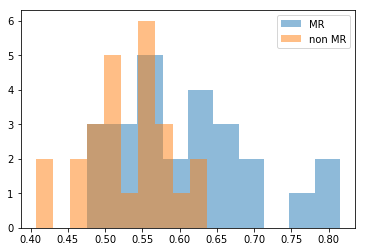

In [9]:
plt.figure()
plt.hist(MR_EF, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_EF, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.show()